In [2]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix, tidyverse,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX,
               EnsDb.Hsapiens.v86, fgsea,AnnotationHub, GenomicRanges,AnnotationDbi,
               logr, parallel, DESeq2,
               pheatmap, ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x, ggnewscale, RColorBrewer, ggalluvial, ggpattern)

# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)
options(scipen = 12)

# Make Bed Traits - Fingenn (Hg38)

In [3]:
# Setup directories
traits.dir = "/nfs/lab/FinnGen_R11/finemap/summary/"
traits.bed.dir = "/nfs/lab/tscc/luca/MEGA_Heart/Traits_Annotation/Inputs/Filtered_snps_Traits_BED/"

traits.meta.path = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/LDSC/TRAITS_pub.meta.txt"

In [4]:
# Grep all traits
files = dir(traits.dir, pattern = ".SUSIE.snp.filter.tsv")
files = files[!grepl(pattern = ".tbi", x = files)]
files = data.frame(files = paste0(traits.dir, files), 
           trait = str_split_fixed(files, ".SUSIE.snp.filter.tsv", n = 2)[,1])

message("all traits found: ", nrow(files))

all traits found: 1250



In [5]:
# Load traits we car about
traits.meta = fread(traits.meta.path, header = TRUE)
colnames(traits.meta)[2] = "Internal_Study_ID"

traits.meta = traits.meta %>%
        dplyr::filter(Internal_Study_ID == "finngen") %>%
        left_join(files, by = "trait")

In [6]:
files = traits.meta
files = dplyr::filter(files, File != "finngen_R11_I9_MI_COMPLICATIONS") # Random trait I don't have susie for
traits.use = files$Phenotype

In [7]:
# Make bed files
for (i in seq_along(traits.use)){
    # Grep files and make names
    file.use = files$files[i]
    trait.use = files$File[i]
    message("Making a bed for ", trait.use)
    out.bed.file = paste(traits.bed.dir, trait.use, "_Hg38.bed", sep = "")
    # Read table
    trait.data = read.table(file.use, header = TRUE)

    # Manipolate table
    trait.data = trait.data %>%
            dplyr::filter(cs != "-1") %>%
            dplyr::mutate(region = gsub(pattern = ":", replacement = "-", x = region),
                   chr = str_split_fixed(string = region, pattern = "-", n = 3)[,1],
                   start = position - 1,
                   end = position,
                   signal = paste0(region, "--", cs)) %>%
            dplyr::select(chr, start, end, trait, 
                          signal, region, cs,
                          v, position, cs_specific_prob, gene_most_severe)
    message("Variants found: ", nrow(trait.data))
    message("Signals found: ", length(unique(trait.data$signal)))   
    
    # Save table
    write.table(trait.data,
                file = out.bed.file,
                col.names = TRUE, row.names = F, sep = "\t", quote = F)
}

Making a bed for finngen_R11_C_STROKE

Variants found: 216

Signals found: 10

Making a bed for finngen_R11_I9_ANGINA

Variants found: 2232

Signals found: 74

Making a bed for finngen_R11_I9_ANGIO

Variants found: 1378

Signals found: 46

Making a bed for finngen_R11_I9_AORTANEUR

Variants found: 1048

Signals found: 22

Making a bed for finngen_R11_I9_CABG

Variants found: 1300

Signals found: 66

Making a bed for finngen_R11_I9_CAVS_OPERATED

Variants found: 1041

Signals found: 27

Making a bed for finngen_R11_I9_CORATHER

Variants found: 2769

Signals found: 103

Making a bed for finngen_R11_I9_HYPTENS

Variants found: 8658

Signals found: 278

Making a bed for finngen_R11_I9_HYPTENSESS

Variants found: 7241

Signals found: 218

Making a bed for finngen_R11_I9_HYPTENSHD

Variants found: 384

Signals found: 17

Making a bed for finngen_R11_I9_REVASC

Variants found: 2920

Signals found: 107

Making a bed for finngen_R11_I9_VHD

Variants found: 530

Signals found: 16

Making a bed f

# Intersect with celltypes peak calls

In [8]:
peaks.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/"

In [9]:
# Order
celltypes = c("vCM", "aCM", "Epicardial", "SM", "Pericyte", "Neuronal",
  "Fibroblast", "Adipocyte", "Endothelial", "Endocardial", "Myeloid", "Lymphoid")

In [10]:
head(files, n = 2)

Phenotype,Internal_Study_ID,File,Priority,trait,files
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
STROKE,finngen,finngen_R11_C_STROKE,Ok,finngen_R11_C_STROKE,/nfs/lab/FinnGen_R11/finemap/summary/finngen_R11_C_STROKE.SUSIE.snp.filter.tsv
Angina pectoris,finngen,finngen_R11_I9_ANGINA,Ok,finngen_R11_I9_ANGINA,/nfs/lab/FinnGen_R11/finemap/summary/finngen_R11_I9_ANGINA.SUSIE.snp.filter.tsv


In [11]:
stats.all = NULL
overlap_data.all = NULL

for (t.i in seq_along(traits.use)){
    print(paste0("   - Processing: ", files$trait[t.i]))
    # Load trait
    trait.data = read.table(paste(traits.bed.dir, files$trait[t.i], "_Hg38.bed", sep = ""), header = TRUE)

    # Gather trait stats
    total.variants = length(unique(trait.data$v))
    total.signals = length(unique(trait.data$signal))

    # Convert to granges
    trait.data_gr <- GRanges(
            seqnames = trait.data$chr,
            ranges = IRanges(start = trait.data$start, end = trait.data$end), 
            mcols = trait.data[,4:ncol(trait.data)]) 
    
        for (c.i in seq_along(celltypes)){
            celltype.use = celltypes[c.i]
            message(" - Intersecting with: ", celltype.use)

            # Load Peaks
            peaks.data = read.table(paste0(peaks.dir, celltype.use, "_peaks.bed")) %>%
                         dplyr::mutate(Peak_ID = paste0(V1, "-", V2, "-", V3))
            
            # Convert to granges
            peaks.data_gr = GRanges(
                        seqnames = peaks.data$V1,
                        ranges = IRanges(start = peaks.data$V2, end = peaks.data$V3), 
                        Peak_ID = peaks.data$Peak_ID)
            
            # bedtools intersect
            overlaps <- findOverlaps(trait.data_gr, peaks.data_gr)
            
            # Extract overlaps
            overlap_traits <- as.data.frame(trait.data_gr[queryHits(overlaps)])
            overlap_traits$Peak_ID <- mcols(peaks.data_gr[subjectHits(overlaps)])$Peak_ID

            # Grab statsfiles
            variant.overlap = length(unique(overlap_traits$mcols.v))
            signal.overlap = length(unique(overlap_traits$mcols.signal))
            peaks.on.variant = length(unique(overlap_traits$Peak_ID))

            # Finalize overlap file to write out
            overlap_data = overlap_traits %>%
                           dplyr::mutate(trait = files$trait[t.i],
                                         celltype = celltype.use,
                                         phenotype = files$Phenotype[t.i], 
                                         chromSTATE = "ATAC")

            stats.tmp = data.frame(trait = files$trait[t.i],
                                   phenotype = files$Phenotype[t.i],
                                   total.variants = total.variants,
                                   total.signals = total.signals,
                                   celltype = celltype.use,
                                   chromSTATE = "ATAC",
                                   total.peaks = nrow(peaks.data),
                                   peaks.on.variant = peaks.on.variant,
                                   variant.overlap = variant.overlap,
                                   signal.overlap = signal.overlap)   
             stats.all = rbind(stats.all, stats.tmp)
             overlap_data.all = rbind(overlap_data, overlap_data.all)       
        }
    
}

[1] "   - Processing: finngen_R11_C_STROKE"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_ANGINA"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_ANGIO"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_AORTANEUR"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_CABG"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_CAVS_OPERATED"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_CORATHER"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_HYPTENS"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_HYPTENSESS"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_HYPTENSHD"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_REVASC"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_VHD"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_FG_CVD"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_FG_OTHHEART"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_CVD_HARD"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_HEARTFAIL_AND_ANTIHYPERT"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_HEARTFAIL_AND_CHD"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_CARDIAC_ARRHYTM"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_FG_DOAAC"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_AF"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_AF_REIMB"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_CARDMYOOTH"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_CHD"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_HEARTFAIL"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_HEARTFAIL_ALLCAUSE"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_HEARTFAIL_EXMORE"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_IHD"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_MI_STRICT"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_NONISCHCARDMYOP_STRICT"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_NONRHEVALV"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



[1] "   - Processing: finngen_R11_I9_OTHARR"


 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



In [12]:
stats.all

trait,phenotype,total.variants,total.signals,celltype,chromSTATE,total.peaks,peaks.on.variant,variant.overlap,signal.overlap
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<int>,<int>,<int>
finngen_R11_C_STROKE,STROKE,216,10,vCM,ATAC,205292,7,7,4
finngen_R11_C_STROKE,STROKE,216,10,aCM,ATAC,175041,6,6,4
finngen_R11_C_STROKE,STROKE,216,10,Epicardial,ATAC,94669,6,6,4
finngen_R11_C_STROKE,STROKE,216,10,SM,ATAC,81405,4,4,3
finngen_R11_C_STROKE,STROKE,216,10,Pericyte,ATAC,103685,6,6,4
finngen_R11_C_STROKE,STROKE,216,10,Neuronal,ATAC,52687,3,3,3
finngen_R11_C_STROKE,STROKE,216,10,Fibroblast,ATAC,173900,10,13,5
finngen_R11_C_STROKE,STROKE,216,10,Adipocyte,ATAC,65394,5,5,3
finngen_R11_C_STROKE,STROKE,216,10,Endothelial,ATAC,130803,11,12,4


# Intersect with chrom states

In [13]:
peaks.dir = "/nfs/lab/tscc/luca/MEGA_Heart/peaks_LDSC_annotate/splitByES/"

# Grep all traits
peaks.ls = dir(peaks.dir, pattern = "_annotated_peaks.bed")

length(peaks.ls)/5 # 5 ES -> 12 celltypes
peaks.ls

[1] 12

[1] "aCM--E1_annotated_peaks.bed"         "aCM--E2_annotated_peaks.bed"        
 [3] "aCM--E3_annotated_peaks.bed"         "aCM--E4_annotated_peaks.bed"        
 [5] "aCM--E5_annotated_peaks.bed"         "Adipocyte--E1_annotated_peaks.bed"  
 [7] "Adipocyte--E2_annotated_peaks.bed"   "Adipocyte--E3_annotated_peaks.bed"  
 [9] "Adipocyte--E4_annotated_peaks.bed"   "Adipocyte--E5_annotated_peaks.bed"  
[11] "Endocardial--E1_annotated_peaks.bed" "Endocardial--E2_annotated_peaks.bed"
[13] "Endocardial--E3_annotated_peaks.bed" "Endocardial--E4_annotated_peaks.bed"
[15] "Endocardial--E5_annotated_peaks.bed" "Endothelial--E1_annotated_peaks.bed"
[17] "Endothelial--E2_annotated_peaks.bed" "Endothelial--E3_annotated_peaks.bed"
[19] "Endothelial--E4_annotated_peaks.bed" "Endothelial--E5_annotated_peaks.bed"
[21] "Epicardial--E1_annotated_peaks.bed"  "Epicardial--E2_annotated_peaks.bed" 
[23] "Epicardial--E3_annotated_peaks.bed"  "Epicardial--E4_annotated_peaks.bed" 
[25] "Epicardial--E5_annotated_peaks.bed"  "Fibroblast--E1_annotated_peaks.bed" 
[27] "Fibroblast--E2_annotated_peaks.bed"  "Fibroblast--E3_annotated_peaks.bed" 
[29] "Fibroblast--E4_annotated_peaks.bed"  "Fibroblast--E5_annotated_peaks.bed" 
[31] "Lymphoid--E1_annotated_peaks.bed"    "Lymphoid--E2_annotated_peaks.bed"   
[33] "Lymphoid--E3_annotated_peaks.bed"    "Lymphoid--E4_annotated_peaks.bed"   
[35] "Lymphoid--E5_annotated_peaks.bed"    "Myeloid--E1_annotated_peaks.bed"    
[37] "Myeloid--E2_annotated_peaks.bed"     "Myeloid--E3_annotated_peaks.bed"    
[39] "Myeloid--E4_annotated_peaks.bed"     "Myeloid--E5_annotated_peaks.bed"    
[41] "Neuronal--E1_annotated_peaks.bed"    "Neuronal--E2_annotated_peaks.bed"   
[43] "Neuronal--E3_annotated_peaks.bed"    "Neuronal--E4_annotated_peaks.bed"   
[45] "Neuronal--E5_annotated_peaks.bed"    "Pericyte--E1_annotated_peaks.bed"   
[47] "Pericyte--E2_annotated_peaks.bed"    "Pericyte--E3_annotated_peaks.bed"   
[49] "Pericyte--E4_annotated_peaks.bed"    "Pericyte--E5_annotated_peaks.bed"   
[51] "SM--E1_annotated_peaks.bed"          "SM--E2_annotated_peaks.bed"         
[53] "SM--E3_annotated_peaks.bed"          "SM--E4_annotated_peaks.bed"         
[55] "SM--E5_annotated_peaks.bed"          "vCM--E1_annotated_peaks.bed"        
[57] "vCM--E2_annotated_peaks.bed"         "vCM--E3_annotated_peaks.bed"        
[59] "vCM--E4_annotated_peaks.bed"         "vCM--E5_annotated_peaks.bed"

In [14]:
# DO NOT re-initialize the stats-files as we want to concatenate them

for (t.i in seq_along(traits.use)){
    print(paste0("   - Processing: ", files$trait[t.i]))
    # Load trait
    trait.data = read.table(paste(traits.bed.dir, files$trait[t.i], "_Hg38.bed", sep = ""), header = TRUE)

    # Gather trait stats
    total.variants = length(unique(trait.data$v))
    total.signals = length(unique(trait.data$signal))

    # Convert to granges
    trait.data_gr <- GRanges(
            seqnames = trait.data$chr,
            ranges = IRanges(start = trait.data$start, end = trait.data$end), 
            mcols = trait.data[,4:ncol(trait.data)]) 
    
        for (c.i in seq_along(peaks.ls)){ 
            peaks.use = peaks.ls[c.i]
            prefix = str_split_fixed(string = peaks.use,
                            pattern = "_",
                            n = 2)[,1]
            celltype.use = str_split_fixed(string = prefix,
                            pattern = "--",
                            n = 2)[,1]
            chromSTATE.use = str_split_fixed(string = prefix,
                            pattern = "--",
                            n = 2)[,2]

            message(" - Intersecting with: ", prefix)
            
            
            # Load Peaks
            peaks.data = read.table(paste0(peaks.dir, peaks.use)) %>%
                         dplyr::mutate(Peak_ID = paste0(V1, "-", V2, "-", V3))
            
            # Convert to granges
            peaks.data_gr = GRanges(
                        seqnames = peaks.data$V1,
                        ranges = IRanges(start = peaks.data$V2, end = peaks.data$V3), 
                        Peak_ID = peaks.data$Peak_ID)

            # bedtools intersect
            overlaps <- findOverlaps(trait.data_gr, peaks.data_gr)
            
            # Extract overlaps
            overlap_traits <- as.data.frame(trait.data_gr[queryHits(overlaps)])
            overlap_traits$Peak_ID <- mcols(peaks.data_gr[subjectHits(overlaps)])$Peak_ID

            # Grab stats
            variant.overlap = length(unique(overlap_traits$mcols.v))
            signal.overlap = length(unique(overlap_traits$mcols.signal))
            peaks.on.variant = length(unique(overlap_traits$Peak_ID))

            # Finalize overlap file to write out
            overlap_data = overlap_traits %>%
                           dplyr::mutate(trait = files$trait[t.i],
                                         celltype = celltype.use,
                                         phenotype = files$Phenotype[t.i], 
                                         chromSTATE = chromSTATE.use)


            stats.tmp = data.frame(trait = files$trait[t.i],
                                   phenotype = files$Phenotype[t.i],
                                   total.variants = total.variants,
                                   total.signals = total.signals,
                                   celltype = celltype.use,
                                   chromSTATE = chromSTATE.use,
                                   total.peaks = nrow(peaks.data),
                                   peaks.on.variant = peaks.on.variant,
                                   variant.overlap = variant.overlap,
                                   signal.overlap = signal.overlap) 
             stats.all = rbind(stats.all, stats.tmp)
             overlap_data.all = rbind(overlap_data, overlap_data.all)       
        }
    
}

[1] "   - Processing: finngen_R11_C_STROKE"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_ANGINA"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_ANGIO"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_AORTANEUR"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_CABG"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_CAVS_OPERATED"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_CORATHER"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_HYPTENS"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_HYPTENSESS"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_HYPTENSHD"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_REVASC"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_VHD"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_FG_CVD"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_FG_OTHHEART"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_CVD_HARD"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_HEARTFAIL_AND_ANTIHYPERT"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_HEARTFAIL_AND_CHD"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_CARDIAC_ARRHYTM"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_FG_DOAAC"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_AF"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_AF_REIMB"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_CARDMYOOTH"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_CHD"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_HEARTFAIL"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_HEARTFAIL_ALLCAUSE"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_HEARTFAIL_EXMORE"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_IHD"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_MI_STRICT"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_NONISCHCARDMYOP_STRICT"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_NONRHEVALV"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

[1] "   - Processing: finngen_R11_I9_OTHARR"


 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

# Integrate results with LDSC

In [16]:
# Load ES states results to load in Active state signficance information
LDSC_path = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/LDSC_ES/FinnGen_CDVKP_MVP.resultsPerCelltype.txt"

LDSC_results = read.table(LDSC_path, header = TRUE) %>%
    dplyr::mutate(ID = paste0(celltype, "--", Histone_mod, "--", trait),
     LDSC_SIG = case_when(
      Enrichment_padj_BH < 0.05 ~ "SIG",
      TRUE ~ "NS")) %>%  
    dplyr::select(ID, Enrichment_padj_BH, LDSC_SIG)

In [17]:
stats.all = stats.all %>%
    dplyr::mutate(ID = paste0(celltype, "--", chromSTATE, "--", trait))%>%
    left_join(LDSC_results, by = "ID")

# Make bings table:

In [25]:
celltype.order =  c("aCM", "vCM", "Myeloid", "Adipocyte", 
                   "Endothelial", "Endocardial", "Epicardial","Neuronal", "Lymphoid",
                   "SM", "Pericyte", "Fibroblast")

ES.order = c("ATAC", "Unknown", "Repressive", "Weak", "Open", "Active")

In [26]:
traits.use = c( "Non-ischemic cardiomyopathy (Strict)", 
                "Atrial fibrillation and flutter",
                "All-cause Heart Failure",
                "Ischaemic heart disease, wide definition",
                "Myocardial infarction, strict",               
                "Hypertension",
                "Aortic aneurysm",
                "Major coronary heart disease event"               
              )

In [27]:
unique(overlap_data.all$trait)

[1] "finngen_R11_I9_OTHARR"                  
 [2] "finngen_R11_I9_NONRHEVALV"              
 [3] "finngen_R11_I9_NONISCHCARDMYOP_STRICT"  
 [4] "finngen_R11_I9_MI_STRICT"               
 [5] "finngen_R11_I9_IHD"                     
 [6] "finngen_R11_I9_HEARTFAIL_EXMORE"        
 [7] "finngen_R11_I9_HEARTFAIL_ALLCAUSE"      
 [8] "finngen_R11_I9_HEARTFAIL"               
 [9] "finngen_R11_I9_CHD"                     
[10] "finngen_R11_I9_CARDMYOOTH"              
[11] "finngen_R11_I9_AF_REIMB"                
[12] "finngen_R11_I9_AF"                      
[13] "finngen_R11_FG_DOAAC"                   
[14] "finngen_R11_CARDIAC_ARRHYTM"            
[15] "finngen_R11_I9_HEARTFAIL_AND_CHD"       
[16] "finngen_R11_I9_HEARTFAIL_AND_ANTIHYPERT"
[17] "finngen_R11_I9_CVD_HARD"                
[18] "finngen_R11_FG_OTHHEART"                
[19] "finngen_R11_FG_CVD"                     
[20] "finngen_R11_I9_VHD"                     
[21] "finngen_R11_I9_REVASC"                  
[22] "finngen_R11_I9_HYPTENSHD"               
[23] "finngen_R11_I9_HYPTENSESS"              
[24] "finngen_R11_I9_HYPTENS"                 
[25] "finngen_R11_I9_CORATHER"                
[26] "finngen_R11_I9_CAVS_OPERATED"           
[27] "finngen_R11_I9_CABG"                    
[28] "finngen_R11_I9_AORTANEUR"               
[29] "finngen_R11_I9_ANGIO"                   
[30] "finngen_R11_I9_ANGINA"                  
[31] "finngen_R11_C_STROKE"

In [28]:
summary_data <- overlap_data.all %>%
    dplyr::mutate(ID = paste0(celltype, "--", chromSTATE, "--", mcols.trait))%>%
    left_join(LDSC_results, by = "ID") %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)),
    chromSTATE = factor(chromSTATE, levels = ES.order)) %>%
  dplyr::filter(chromSTATE %in% c("Active")) %>%
  dplyr::filter(phenotype %in% traits.use) %>%
  dplyr::mutate(phenotype = factor(phenotype, levels = traits.use)) %>%
  dplyr::group_by(phenotype) %>%
  dplyr::summarize(
    variant.overlap = length(unique(mcols.v)),
    signal.overlap = length(unique(mcols.signal)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop" # To ungroup after summarizing
  )

summary_data

phenotype,variant.overlap,signal.overlap,peaks.on.variant
<fct>,<int>,<int>,<int>
Non-ischemic cardiomyopathy (Strict),24,3,67
Atrial fibrillation and flutter,215,72,466
All-cause Heart Failure,23,6,62
"Ischaemic heart disease, wide definition",210,55,398
"Myocardial infarction, strict",193,39,338
Hypertension,711,178,1472
Aortic aneurysm,60,14,121
Major coronary heart disease event,217,53,409


In [29]:
summary_data <- overlap_data.all %>%
  dplyr::mutate(
    ID = paste0(celltype, "--", chromSTATE, "--", trait)
  ) %>%
  left_join(LDSC_results, by = "ID") %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order),
    phenotype = factor(phenotype, levels = traits.use)
  ) %>%
  dplyr::filter(phenotype %in% traits.use) %>%
  dplyr::group_by(phenotype, chromSTATE, LDSC_SIG) %>%
  dplyr::summarize(
    variant.overlap = length(unique(mcols.v)),
    signal.overlap = length(unique(mcols.signal)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop" # Ungroup after summarizing
  )%>%
  dplyr::mutate(celltype = "Any")

In [30]:
summary_data %>%
  dplyr::filter(chromSTATE == "Active")

phenotype,chromSTATE,LDSC_SIG,variant.overlap,signal.overlap,peaks.on.variant,celltype
<fct>,<fct>,<chr>,<int>,<int>,<int>,<chr>
Non-ischemic cardiomyopathy (Strict),Active,NS,23,3,54,Any
Non-ischemic cardiomyopathy (Strict),Active,SIG,12,3,13,Any
Atrial fibrillation and flutter,Active,NS,124,47,229,Any
Atrial fibrillation and flutter,Active,SIG,161,64,237,Any
All-cause Heart Failure,Active,NS,20,4,46,Any
All-cause Heart Failure,Active,SIG,18,5,16,Any
"Ischaemic heart disease, wide definition",Active,NS,77,29,72,Any
"Ischaemic heart disease, wide definition",Active,SIG,184,54,326,Any
"Myocardial infarction, strict",Active,NS,159,36,235,Any


In [31]:
summary_data_CT <- overlap_data.all %>%
  dplyr::mutate(
    ID = paste0(celltype, "--", chromSTATE, "--", trait)
  ) %>%
  left_join(LDSC_results, by = "ID") %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order),
    phenotype = factor(phenotype, levels = traits.use)
  ) %>%
  dplyr::filter(phenotype %in% traits.use) %>%
  dplyr::group_by(phenotype, chromSTATE, celltype, LDSC_SIG) %>%
  dplyr::summarize(
    variant.overlap = length(unique(mcols.v)),
    signal.overlap = length(unique(mcols.signal)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop" # Ungroup after summarizing
  )

In [32]:
summary_data_CT %>%
  dplyr::filter(LDSC_SIG == "SIG" & chromSTATE == "Active")

phenotype,chromSTATE,celltype,LDSC_SIG,variant.overlap,signal.overlap,peaks.on.variant
<fct>,<fct>,<fct>,<chr>,<int>,<int>,<int>
Non-ischemic cardiomyopathy (Strict),Active,aCM,SIG,9,3,6
Non-ischemic cardiomyopathy (Strict),Active,vCM,SIG,12,3,7
Atrial fibrillation and flutter,Active,aCM,SIG,115,53,84
Atrial fibrillation and flutter,Active,vCM,SIG,116,53,85
Atrial fibrillation and flutter,Active,SM,SIG,47,23,30
Atrial fibrillation and flutter,Active,Pericyte,SIG,58,26,38
All-cause Heart Failure,Active,aCM,SIG,16,5,10
All-cause Heart Failure,Active,SM,SIG,13,3,6
"Ischaemic heart disease, wide definition",Active,aCM,SIG,85,39,60


# Plot variants

In [38]:
# Colors
cols <- c("#036EB8", "#cd5c5c", "#c0c0c0", "#008000", "#ffc800", '#66cdaa')
names(cols) <- c("ATAC", "Repressive", "Unknown", "Open", "Weak", "Active")

In [39]:
unique(stats.all$phenotype)

[1] "STROKE"                                                    
 [2] "Angina pectoris"                                           
 [3] "Coronary angioplasty"                                      
 [4] "Aortic aneurysm"                                           
 [5] "Coronary artery bypass grafting"                           
 [6] "Calcific aortic valvular stenosis, operated"               
 [7] "Coronary atherosclerosis"                                  
 [8] "Hypertension"                                              
 [9] "Hypertension, essential"                                   
[10] "Hypertensive Heart Disease"                                
[11] "Coronary revascularization (ANGIO or CABG)"                
[12] "Valvular heart disease excluding rheumatic fever"          
[13] "Cardiovascular diseases (excluding rheumatic etc)"         
[14] "Other heart diseases"                                      
[15] "Hard cardiovascular diseases"                              
[16] "Heart failure and antihypertensive medication"             
[17] "Heart failure and coronary heart disease"                  
[18] "Cardiac arrhythmias"                                       
[19] "Diseases of arteries, arterioles and capillaries (FINNGEN)"
[20] "Atrial fibrillation and flutter"                           
[21] "Atrial fibrillation and flutter with reimbursement"        
[22] "Cardiomyopathy, other and unspecified"                     
[23] "Major coronary heart disease event"                        
[24] "Heart failure, strict"                                     
[25] "All-cause Heart Failure"                                   
[26] "Heart failure, strict (more control exclusions)"           
[27] "Ischaemic heart disease, wide definition"                  
[28] "Myocardial infarction, strict"                             
[29] "Non-ischemic cardiomyopathy (Strict)"                      
[30] "Non-rheumatic valve diseases"                              
[31] "Other arrhythmias"

In [42]:
variant.plot = 'Ischaemic heart disease, wide definition'
celltypes.plot = c('aCM', 'vCM','Endothelial', 'Endocardial', 'Neuronal', 'SM', 'Pericyte', 'Fibroblast')
states.plot = c("ATAC", "Open", "Active")

In [43]:
unique(stats.all$celltype)

[1] "vCM"         "aCM"         "Epicardial"  "SM"          "Pericyte"   
 [6] "Neuronal"    "Fibroblast"  "Adipocyte"   "Endothelial" "Endocardial"
[11] "Myeloid"     "Lymphoid"

In [44]:
plot.data = dplyr::filter(stats.all, phenotype %in% variant.plot) %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)),
      chromSTATE = factor(chromSTATE, levels = ES.order)
  )

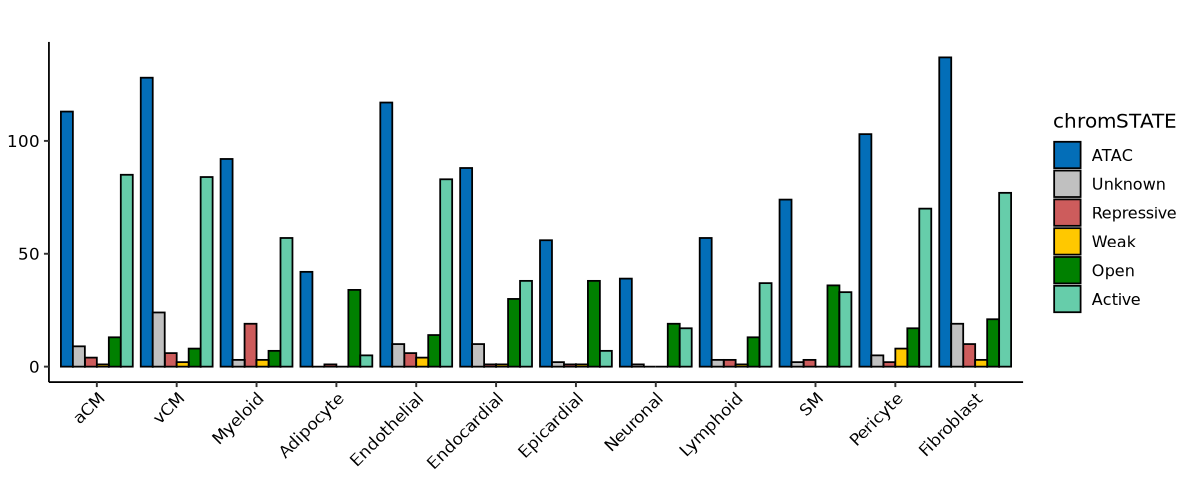

In [45]:
options(repr.plot.width=10, repr.plot.height=4)
# Plot all celltypes
ggplot(plot.data, aes(x = celltype, y = variant.overlap, fill = chromSTATE)) +
  geom_bar(stat = "identity", color = "black", position = position_dodge()) +
  scale_fill_manual(values = cols) +  # Use custom colors
  labs(title = "") +
  theme_pubr() +  # Minimal theme with base size
  theme(
    axis.title = element_blank(),  # Remove axis titles
    axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.position = "right"
)

In [46]:
# Subset plot data to only what we care about
plot.data = dplyr::filter(plot.data,
                celltype %in% celltypes.plot &
                phenotype %in% variant.plot &
                chromSTATE %in% states.plot) %>%
            dplyr::select(phenotype, celltype, chromSTATE, variant.overlap, signal.overlap, peaks.on.variant)

# Gather the information of "any celltype"
summary_data.use = overlap_data.all %>%
  dplyr::mutate(
    ID = paste0(celltype, "--", chromSTATE, "--", trait)
  ) %>%
  left_join(LDSC_results, by = "ID") %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order),
    phenotype = factor(phenotype, levels = traits.use)
  ) %>%
  dplyr::filter(celltype %in% celltypes.plot &
                phenotype %in% variant.plot &
                chromSTATE %in% states.plot) %>%
  dplyr::group_by(phenotype, chromSTATE) %>%
  dplyr::summarize(
    variant.overlap = length(unique(mcols.v)),
    signal.overlap = length(unique(mcols.signal)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop" # Ungroup after summarizing
  )%>%
  dplyr::mutate(celltype = "Any") %>%
    dplyr::select(phenotype, celltype, chromSTATE, variant.overlap, signal.overlap, peaks.on.variant)

# Add it all together and complete cases if states are missing
plot.data <- bind_rows(plot.data, summary_data.use) %>%
  mutate(
    celltype = factor(celltype, levels = c("Any", celltypes.plot)),
    chromSTATE = factor(chromSTATE, levels = states.plot)
  ) %>%
  complete(
    phenotype,
    celltype,
    chromSTATE,
    fill = list(
      variant.overlap = 0,
      signal.overlap = 0,
      peaks.on.variant = 0))

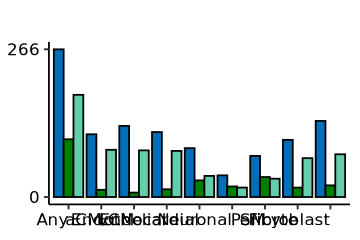

In [50]:
gg = ggplot(plot.data, aes(x = celltype, y = variant.overlap, fill = chromSTATE)) +
  geom_bar(stat = "identity", color = "black", position = position_dodge()) +
  scale_fill_manual(values = cols) +  # Use custom colors
  labs(title = "") +
  theme_pubr() +  # Minimal theme with base size +
  scale_y_continuous(
    breaks = c(0, max(plot.data$variant.overlap)))+
  theme(
    axis.title = element_blank(),  # Remove axis titles
    axis.text.x = element_text(size = 10, hjust = 1),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.position = "none"
  )

options(repr.plot.width=3, repr.plot.height=2)
gg

In [51]:
# 1 witdth per celltype

In [52]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", gsub(" ", "_", variant.plot), "_snp.pdf"),
                            width = 3, height = 2, 
                            plot = gg, device = "pdf")

# Plot Signal

In [53]:
plot.data = dplyr::filter(stats.all, phenotype %in% variant.plot) %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)),
      chromSTATE = factor(chromSTATE, levels = ES.order)
  )

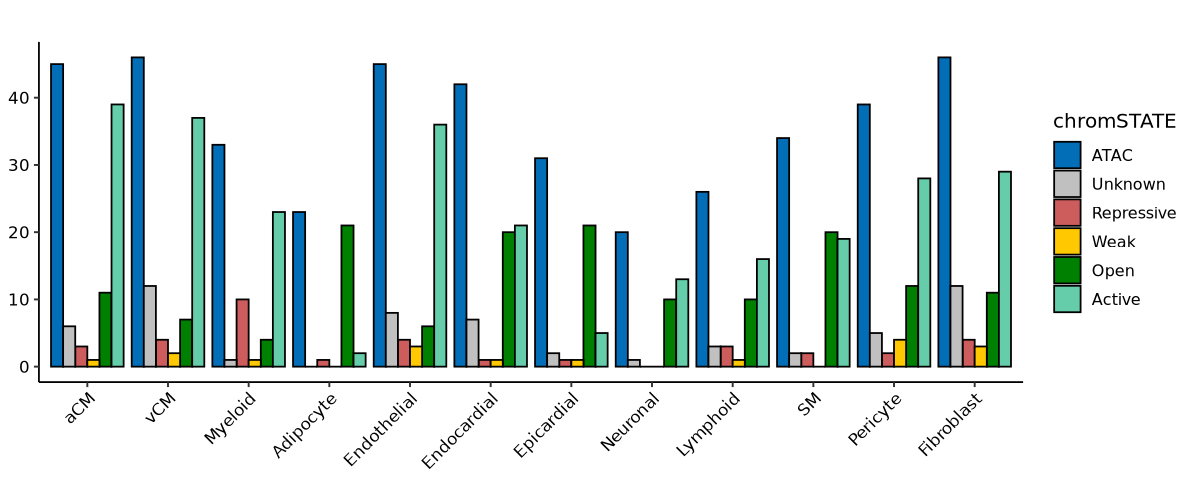

In [54]:
options(repr.plot.width=10, repr.plot.height=4)
# Plot pie charts for each celltype
ggplot(plot.data, aes(x = celltype, y = signal.overlap, fill = chromSTATE)) +
  geom_bar(stat = "identity", color = "black", position = position_dodge()) +
  scale_fill_manual(values = cols) +  # Use custom colors
  labs(title = "") +
  theme_pubr() +  # Minimal theme with base size
  theme(
    axis.title = element_blank(),  # Remove axis titles
    axis.text.x = element_text(size = 10, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.position = "right"
)

In [55]:
# Subset plot data to only what we care about
plot.data = dplyr::filter(plot.data,
                celltype %in% celltypes.plot &
                phenotype %in% variant.plot &
                chromSTATE %in% states.plot) %>%
            dplyr::select(phenotype, celltype, chromSTATE, variant.overlap, signal.overlap, peaks.on.variant)

# Gather the information of "any celltype"
summary_data.use = overlap_data.all %>%
  dplyr::mutate(
    ID = paste0(celltype, "--", chromSTATE, "--", trait)
  ) %>%
  left_join(LDSC_results, by = "ID") %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order),
    phenotype = factor(phenotype, levels = traits.use)
  ) %>%
  dplyr::filter(celltype %in% celltypes.plot &
                phenotype %in% variant.plot &
                chromSTATE %in% states.plot) %>%
  dplyr::group_by(phenotype, chromSTATE) %>%
  dplyr::summarize(
    variant.overlap = length(unique(mcols.v)),
    signal.overlap = length(unique(mcols.signal)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop" # Ungroup after summarizing
  )%>%
  dplyr::mutate(celltype = "Any") %>%
    dplyr::select(phenotype, celltype, chromSTATE, variant.overlap, signal.overlap, peaks.on.variant)

# Add it all together and complete cases if states are missing
plot.data <- bind_rows(plot.data, summary_data.use) %>%
  mutate(
    celltype = factor(celltype, levels = c("Any", celltypes.plot)),
    chromSTATE = factor(chromSTATE, levels = states.plot)
  ) %>%
  complete(
    phenotype,
    celltype,
    chromSTATE,
    fill = list(
      variant.overlap = 0,
      signal.overlap = 0,
      peaks.on.variant = 0))

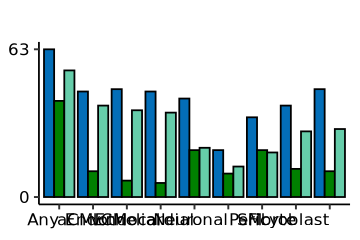

In [56]:
gg = ggplot(plot.data, aes(x = celltype, y = signal.overlap, fill = chromSTATE)) +
  geom_bar(stat = "identity", color = "black", position = position_dodge()) +
  scale_fill_manual(values = cols) +  # Use custom colors
  labs(title = "") +
  theme_pubr() +  # Minimal theme with base size +
  scale_y_continuous(
    breaks = c(0, max(plot.data$signal.overlap)))+
  theme(
    axis.title = element_blank(),  # Remove axis titles
    axis.text.x = element_text(size = 10, hjust = 1),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.position = "none"
  )

options(repr.plot.width=3, repr.plot.height=2)
gg

In [57]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", gsub(" ", "_", variant.plot), "_signal.pdf"),
                            width = 3, height = 2, 
                            plot = gg, device = "pdf")

# Pull out peaks that we want to use for all of the downstream 

In [655]:
# Print all variants that overlap in the active state for all enriched celltypes
data.print = overlap_data.all %>%
  dplyr::mutate(
    ID = paste0(celltype, "--", chromSTATE, "--", trait)
  ) %>%
  left_join(LDSC_results, by = "ID") %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order)) %>%
    dplyr::filter(LDSC_SIG == "SIG" &
                chromSTATE == "Active") %>%
  mutate(Peak_ID = as.character(Peak_ID)) %>%
  separate(
    col = Peak_ID,
    into = c("chr", "start", "end"),
    sep = "-", # Split on the '-' character
    remove = FALSE, # Keep the original Peak_ID column
    convert = TRUE # Convert start and end to numeric
  )%>%
  dplyr::select(chr, start, end, Peak_ID,
                celltype, phenotype, trait, chromSTATE, ID,
                region = mcols.region, signal = mcols.signal, variant = mcols.v,
                cs_specific_prob = mcols.cs_specific_prob, gene_most_severe = mcols.gene_most_severe,
                LDSC_celltypeTOtrait_PADJ = Enrichment_padj_BH)

In [657]:
head(data.print, n = 2)

,chr,start,end,Peak_ID,celltype,phenotype,trait,chromSTATE,ID,region,signal,variant,cs_specific_prob,gene_most_severe,LDSC_celltypeTOtrait_PADJ
,<chr>,<int>,<int>,<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,chr2,200305895,200307763,chr2-200305895-200307763,vCM,Other arrhythmias,finngen_R11_I9_OTHARR,Active,vCM--E5--finngen_R11_I9_OTHARR,chr2-198868139-201868139,chr2-198868139-201868139--1,2:200306291:G:C,0.023334655,SPATS2L,0.01352719
2,chr2,200305895,200307763,chr2-200305895-200307763,vCM,Other arrhythmias,finngen_R11_I9_OTHARR,Active,vCM--E5--finngen_R11_I9_OTHARR,chr2-198868139-201868139,chr2-198868139-201868139--1,2:200306468:C:G,0.004584342,SPATS2L,0.01352719


In [666]:
unique(data.print$celltype)
length(unique(data.print$v))
length(unique(data.print$signal))
length(unique(data.print$Peak_ID))
unique(data.print$phenotype)

[1] vCM         SM          aCM         Pericyte    Fibroblast  Endothelial
[7] Endocardial Neuronal   
12 Levels: aCM vCM Myeloid Adipocyte Endothelial Endocardial ... Fibroblast

[1] 1693

[1] 788

[1] 2557

[1] "Other arrhythmias"                                         
 [2] "Non-rheumatic valve diseases"                              
 [3] "Non-ischemic cardiomyopathy (Strict)"                      
 [4] "Myocardial infarction, strict"                             
 [5] "Ischaemic heart disease, wide definition"                  
 [6] "Heart failure, strict (more control exclusions)"           
 [7] "All-cause Heart Failure"                                   
 [8] "Heart failure, strict"                                     
 [9] "Major coronary heart disease event"                        
[10] "Atrial fibrillation and flutter with reimbursement"        
[11] "Atrial fibrillation and flutter"                           
[12] "Diseases of arteries, arterioles and capillaries (FINNGEN)"
[13] "Cardiac arrhythmias"                                       
[14] "Heart failure and coronary heart disease"                  
[15] "Heart failure and antihypertensive medication"             
[16] "Hard cardiovascular diseases"                              
[17] "Other heart diseases"                                      
[18] "Cardiovascular diseases (excluding rheumatic etc)"         
[19] "Valvular heart disease excluding rheumatic fever"          
[20] "Coronary revascularization (ANGIO or CABG)"                
[21] "Hypertensive Heart Disease"                                
[22] "Hypertension, essential"                                   
[23] "Hypertension"                                              
[24] "Coronary atherosclerosis"                                  
[25] "Calcific aortic valvular stenosis, operated"               
[26] "Coronary artery bypass grafting"                           
[27] "Aortic aneurysm"                                           
[28] "Coronary angioplasty"                                      
[29] "Angina pectoris"

In [661]:
# Save table
write.table(data.print,
            file = "/nfs/lab/tscc/luca/MEGA_Heart/Traits_Annotation/results/FinemappedVariants_PeakCalls_ActiveChrom_allFinGenn.bed",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

## Only traits in table

In [662]:
traits.table = c("Non-ischemic cardiomyopathy (Strict)", "Atrial fibrillation and flutter",
                "All-cause Heart Failure", "Ischaemic heart disease, wide definition", 
                "Myocardial infarction, strict", "Hypertension", "Aortic aneurysm", 
                "Major coronary heart disease event")

In [663]:
# Print all variants that overlap in the active state for all enriched celltypes
data.print.sub = dplyr::filter(data.print, phenotype %in% traits.table)

In [664]:
unique(data.print.sub$phenotype)

[1] "Non-ischemic cardiomyopathy (Strict)"    
[2] "Myocardial infarction, strict"           
[3] "Ischaemic heart disease, wide definition"
[4] "All-cause Heart Failure"                 
[5] "Major coronary heart disease event"      
[6] "Atrial fibrillation and flutter"         
[7] "Hypertension"                            
[8] "Aortic aneurysm"

In [667]:
# Save table
write.table(data.print.sub,
            file = "/nfs/lab/tscc/luca/MEGA_Heart/Traits_Annotation/results/FinemappedVariants_PeakCalls_ActiveChrom_TableTraits.bed",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

# Intersect with ABC links and finalize table

In [737]:
ABClinks.path = "/nfs/lab/tscc/luca/MEGA_Heart/ABC/FNIH_Heart.celltype_specific_abclinks_w_score.txt"
results.dir = "/nfs/lab/tscc/luca/MEGA_Heart/Traits_Annotation/results/"

In [738]:
# The ABC links are actually NOT specific, I have to attach that information
ABC.links = read.table(ABClinks.path,
                        sep = '\t', header = TRUE)%>%
  mutate(
    chr = sub(":.*", "", range),                             
    start = as.numeric(sub(".*:(\\d+)-.*", "\\1", range)),   
    end = as.numeric(sub(".*-(\\d+)", "\\1", range))         
  ) %>%
  dplyr::select(chr, start, end, CellType, 
                Link = range, TargetGene, Score = ABC.Score)


In [739]:
# Convert to granges
PeakTraits_Overlap_gr <- GRanges(
        seqnames = data.print$chr,
        ranges = IRanges(start = data.print$start, end = data.print$end), 
        PeakTraits_Overlap = data.print[,4:ncol(data.print)]) 

# Convert to granges
ABCLinks_gr <- GRanges(
        seqnames = ABC.links$chr,
        ranges = IRanges(start = ABC.links$start, end = ABC.links$end), 
        ABC = ABC.links[,4:ncol(ABC.links)])
# bedtools intersect
overlaps <- findOverlaps(PeakTraits_Overlap_gr, ABCLinks_gr)

# Extract overlaps
overlap_PeakTraits <- as.data.frame(PeakTraits_Overlap_gr[queryHits(overlaps)])

# Extract overlapping entries
overlap_peaks <- as.data.frame(PeakTraits_Overlap_gr[queryHits(overlaps)])
overlap_abc <- as.data.frame(ABCLinks_gr[subjectHits(overlaps)])

# Combine data from both sources
overlap_combined <- cbind(overlap_peaks, overlap_abc)

In [740]:
colnames(overlap_combined)

[1] "seqnames"                                    
 [2] "start"                                       
 [3] "end"                                         
 [4] "width"                                       
 [5] "strand"                                      
 [6] "PeakTraits_Overlap.Peak_ID"                  
 [7] "PeakTraits_Overlap.celltype"                 
 [8] "PeakTraits_Overlap.phenotype"                
 [9] "PeakTraits_Overlap.trait"                    
[10] "PeakTraits_Overlap.chromSTATE"               
[11] "PeakTraits_Overlap.ID"                       
[12] "PeakTraits_Overlap.region"                   
[13] "PeakTraits_Overlap.signal"                   
[14] "PeakTraits_Overlap.variant"                  
[15] "PeakTraits_Overlap.cs_specific_prob"         
[16] "PeakTraits_Overlap.gene_most_severe"         
[17] "PeakTraits_Overlap.LDSC_celltypeTOtrait_PADJ"
[18] "seqnames"                                    
[19] "start"                                       
[20] "end"                                         
[21] "width"                                       
[22] "strand"                                      
[23] "ABC.CellType"                                
[24] "ABC.Link"                                    
[25] "ABC.TargetGene"                              
[26] "ABC.Score"

In [758]:
overlap_combined %>%
    dplyr::select(PeakTraits_Overlap.Peak_ID, ABC.Link, PeakTraits_Overlap.celltype, PeakTraits_Overlap.phenotype, 
                ABC.CellType, PeakTraits_Overlap.gene_most_severe, ABC.TargetGene) %>%
    dplyr::filter(PeakTraits_Overlap.celltype == "vCM")

PeakTraits_Overlap.Peak_ID,ABC.Link,PeakTraits_Overlap.celltype,PeakTraits_Overlap.phenotype,ABC.CellType,PeakTraits_Overlap.gene_most_severe,ABC.TargetGene
<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,SM,CAV2,AC002066.1
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,vCM,CAV2,AC002066.1
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,aCM,CAV2,AC006159.1
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,Endothelial,CAV2,AC006159.1
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,aCM,CAV2,CAPZA2
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,Endothelial,CAV2,CAPZA2
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,vCM,CAV2,CAV1
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,SM,CAV2,CAV1
chr7-116511360-116512837,chr7:116512044-116512344,vCM,Other arrhythmias,aCM,CAV2,CAV1


In [759]:
results.summary = overlap_combined %>%
    dplyr::select(PeakTraits_Overlap.Peak_ID, ABC.Link, PeakTraits_Overlap.celltype, PeakTraits_Overlap.phenotype, 
                ABC.CellType, PeakTraits_Overlap.gene_most_severe, ABC.TargetGene)%>%
    dplyr::filter(PeakTraits_Overlap.celltype == ABC.CellType) %>%
    dplyr::group_by(PeakTraits_Overlap.phenotype) %>%
    dplyr::summarize(gene.targets = length(unique(ABC.TargetGene)),
                    .groups = "drop")
results.summary

PeakTraits_Overlap.phenotype,gene.targets
<chr>,<int>
All-cause Heart Failure,3
Angina pectoris,1
Atrial fibrillation and flutter,5
Atrial fibrillation and flutter with reimbursement,4
"Calcific aortic valvular stenosis, operated",4
Cardiac arrhythmias,5
Cardiovascular diseases (excluding rheumatic etc),9
Coronary angioplasty,1
Coronary artery bypass grafting,1


In [753]:
results.summary %>%
            dplyr::filter(PeakTraits_Overlap.phenotype %in% traits.table)

PeakTraits_Overlap.phenotype,gene.targets
<chr>,<int>
All-cause Heart Failure,3
Aortic aneurysm,1
Atrial fibrillation and flutter,7
Hypertension,58
"Ischaemic heart disease, wide definition",9
Major coronary heart disease event,7


In [756]:
results.summary = overlap_combined %>%
    dplyr::select(PeakTraits_Overlap.Peak_ID, ABC.Link, PeakTraits_Overlap.celltype, PeakTraits_Overlap.phenotype, 
                ABC.CellType, PeakTraits_Overlap.gene_most_severe, ABC.TargetGene)%>%
    dplyr::filter(PeakTraits_Overlap.celltype == ABC.CellType) %>%
    dplyr::group_by(PeakTraits_Overlap.celltype, PeakTraits_Overlap.phenotype) %>%
    dplyr::summarize(gene.targets = length(unique(ABC.TargetGene)),
                    .groups = "drop")
results.summary

PeakTraits_Overlap.celltype,PeakTraits_Overlap.phenotype,gene.targets
<fct>,<chr>,<int>
aCM,All-cause Heart Failure,3
aCM,Atrial fibrillation and flutter,4
aCM,Atrial fibrillation and flutter with reimbursement,4
aCM,"Calcific aortic valvular stenosis, operated",1
aCM,Cardiac arrhythmias,4
aCM,"Heart failure, strict (more control exclusions)",3
aCM,Hypertension,5
aCM,"Hypertension, essential",3
aCM,Other arrhythmias,3


In [746]:
# Save table
write.table(overlap_combined,
            file = "/nfs/lab/tscc/luca/MEGA_Heart/Traits_Annotation/results/FinemappedVariants_PeakCalls_ActiveChrom_ABC_allFinGenn.bed",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

# Intersect with Differential CREs